<a target="_blank" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/060_freq_distr.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

(freq-distr-notebook)=
# Dati e frequenze

In questo capitolo, esploreremo le strategie per sintetizzare grandi quantità di dati. Discuteremo il calcolo e l'interpretazione delle distribuzioni di frequenza e dei quantili, oltre alle tecniche di visualizzazione che ci permettono di rappresentare graficamente queste sintesi di dati. Prima di procedere con il presente capitolo, è indispensabile leggere l'appendice dedicata al {ref}`sec-appendix-sums`.

:::{admonition} Obiettivi di apprendimento
:class: tip

Dopo la lettura di questo capitolo dovresti

- sapere come importare le necessarie librerie in un Jupyter Notebook;
- sapere importare i dati da un file esterno;
- essere in grado di estrarre e manipolare le colonne di un DataFrame Pandas;
- generare la distribuzione di frequenze di una variabile qualitativa partendo dai dati grezzi;
- generare e capire una distribuzione congiunta di frequenze, partendo dai dati grezzi;
- creare un istogramma partendo dai dati grezzi, sia svolgendo il compito "a mano", nel caso di un piccolo set di dati, sia usando Python;
- generare un KDE plot usando Python;
- interpretare gli istogrammi e i KDE plot.
:::


## I dati grezzi

Per illustrare i principali strumenti della statistica descrittiva, analizzeremo i dati raccolti da {cite:t}`zetsche_2019future` in uno studio che indaga le aspettative negative come meccanismo chiave nel mantenimento e nella reiterazione della depressione. Nello specifico, i ricercatori si sono proposti di determinare se gli individui depressi sviluppano aspettative accurate riguardo al loro umore futuro o se tali aspettative sono distortamente negative.

Uno dei loro studi ha coinvolto un campione di 30 soggetti con almeno un episodio depressivo maggiore, confrontati con un gruppo di controllo composto da 37 individui sani. La misurazione del livello di depressione è stata effettuata tramite il *Beck Depression Inventory* (BDI-II).

Il BDI-II è uno strumento di autovalutazione utilizzato per valutare la gravità della depressione in adulti e adolescenti. Il test è stato sviluppato per identificare e misurare l'intensità dei sintomi depressivi sperimentati nelle ultime due settimane. I 21 item del test sono valutati su una scala a 4 punti, dove 0 rappresenta il grado più basso e 3 il grado più elevato di sintomatologia depressiva. Il punteggio totale ottenuto nel test viene valutato secondo i seguenti intervalli:

- 0-13: punteggio normale o livelli minimi di depressione considerati clinicamente non significativi;
- 14-19: depressione lieve-moderata;
- 20-28: depressione moderata-severa;
- 29-63: livelli estremamente severi di depressione.

Nell'esercizio successivo, ci proponiamo di analizzare i punteggi di depressione BDI-II nel campione di dati fornito da {cite:t}`zetsche_2019future`.

## Preparazione del Notebook

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

I dati messi a disposizione da {cite:t}`zetsche_2019future` sono memorizzati nel file `data.mood.csv` contenuto nella directory `data`. La cella seguente legge i contenuti del file e li inserisce nel DataFrame `df`.

In [3]:
df = pd.read_csv("../data/data.mood.csv")

Per conoscere le dimensioni del DataFrame utilizzo il metodo `shape()`.

In [4]:
df.shape

(1188, 44)

Il DataFrame ha 1188 righe e 44 colonne. Visualizzo il nome delle colonne con il metodo `.columns`.

In [5]:
df.columns

Index(['Unnamed: 0', 'vpn_nr', 'esm_id', 'group', 'bildung', 'bdi',
       'nr_of_episodes', 'nobs_mood', 'trigger_counter', 'form', 'traurig_re',
       'niedergeschlagen_re', 'unsicher_re', 'nervos_re', 'glucklich_re',
       'frohlich_re', 'mood_sad.5', 'mood_fearful.5', 'mood_neg.5',
       'mood_happy.5', 'cesd_sum', 'rrs_sum', 'rrs_brood', 'rrs_reflect',
       'forecast_sad', 'forecast_fear', 'forecast_neg', 'forecast_happy',
       'recall_sad', 'recall_fear', 'recall_neg', 'recall_happy',
       'diff_neg.fore.5', 'diff_sad.fore.5', 'diff_fear.fore.5',
       'diff_happy.fore.5', 'diff_neg.retro.5', 'diff_sad.retro.5',
       'diff_fear.retro.5', 'diff_happy.retro.5', 'mood_sad5_tm1',
       'mood_neg5_tm1', 'mood_fearful5_tm1', 'mood_happy5_tm1'],
      dtype='object')

Nel presente esercizio, esamineremo solo tre colonne: il codice del soggetto `esm_id`, il gruppo `group` e il valore BDI-II `bdi`. La cella seguente visualizza le prime cinque righe di queste tre colonne.

In [6]:
df = df[["esm_id", "group", "bdi"]]
df.head()

,esm_id,group,bdi
0,10,mdd,25.0
1,10,mdd,25.0
2,10,mdd,25.0
3,10,mdd,25.0
4,10,mdd,25.0


Notiamo che il valore BDI-II è ripetuto varie volte per ogni soggetto. È dunque necessario semplificare il DataFrame in modo tale da avere un unico valore BDI-II per ogni soggetto. Questo risultato si può ottenere applicando la funzione `drop_duplicates()`. L'argomento `keep='first'` specifica che, di tutte le righe presenti per ciascun soggetto terrà la prima (nel caso presente, sono tutte uguali).

In [7]:
df = df.drop_duplicates(keep="first")

Verifico di avere ottenuto il risultato desiderato.

In [8]:
df.shape

(67, 3)

In [9]:
df.head()

,esm_id,group,bdi
0,10,mdd,25.0
14,9,mdd,30.0
29,6,mdd,26.0
45,7,mdd,35.0
64,12,mdd,44.0


Si noti che il nuovo DataFrame (con 67 righe) conserva il "nome" delle righe (ovvero, l'indice di riga) del DataFrame originario (con 1188 righe). Per esempio, il secondo soggetto (con codice identificativo 9) si trova sulla seconda riga del DataFrame, ma il suo indice di riga è 15. Questo non ha nessuna conseguenza perché non useremo l'indice di riga nelle analisi seguenti.

Esamino i valori BDI-II:

In [11]:
print(df["bdi"])

0       25.0
14      30.0
29      26.0
45      35.0
64      44.0
        ... 
1104     0.0
1120     2.0
1132     0.0
1151     0.0
1170     1.0
Name: bdi, Length: 67, dtype: float64


Noto che c'è un dato mancante `nan`. Usano la funzione `notnull()`, trasformiamo il DataFrame in modo da escludere tale dato perché altrimenti interferirà con le analisi statistiche successive.

In [12]:
df = df[pd.notnull(df["bdi"])]

Otteniamo così il DataFrame finale per gli scopi presenti (66 righe e 3 colonne):

In [13]:
df.shape

(66, 3)

Stampiamo i valori BDI-II presentandoli ordinati dal più piccolo al più grande:

In [15]:
print(df["bdi"].sort_values())

682     0.0
455     0.0
465     0.0
485     0.0
540     0.0
       ... 
190    39.0
810    41.0
150    43.0
135    43.0
64     44.0
Name: bdi, Length: 66, dtype: float64


È chiaro dall'elenco precedente che i dati grezzi non sono molto informativi. Nella sezione successiva vedremo come creare una rappresentazione sintetica e comprensibile di questi dati.

## Distribuzioni di frequenze

Una delle metodologie utilizzate per sintetizzare un insieme di dati è la creazione di una distribuzione di frequenze. Questa distribuzione rappresenta il conteggio delle volte in cui si verificano le diverse modalità osservate all'interno di un intervallo di valori in un determinato insieme di dati. In altre parole, la distribuzione di frequenze della variabile $X$ riporta la frequenza associata a ciascun valore possibile di $X$.

Quando la variabile X presenta un numero moderato di modalità, è possibile utilizzare il metodo descritto precedentemente, che consiste nel contare quante volte ogni modalità si verifica nel campione o nella popolazione. Tuttavia, se il numero di modalità è elevato, per costruire una distribuzione di frequenze, è possibile suddividere le modalità della variabile di interesse in m classi disgiunte (indicate come $\Delta_i$). Ogni classe $\Delta_i$ rappresenta un intervallo di valori aperto a destra $[a_i, b_i)$ o aperto a sinistra $(a_i, b_i]$. Ad ogni classe $\Delta_i$, con limiti inferiori e superiori $a_i$ e $b_i$, vengono associati un'ampiezza $b_i - a_i$ (che non è necessariamente uguale per ogni classe) e un valore centrale $\bar{x}_i$. La scelta delle classi è arbitraria, ma si consiglia di evitare di definirne con un numero di osservazioni troppo basso (< 5). Poiché ogni osservazione $x_i$ appartiene a una sola classe $\Delta_i$, è possibile calcolare le seguenti quantità.

-   La *frequenza assoluta* $n_i$ di ciascuna classe, ovvero il numero di osservazioni che ricadono nella classe $\Delta_i$.
    -   Proprietà: $n_1 + n_2 + \dots + n_m = n$.
-   La *frequenza relativa* $f_i = n_i/n$ di ciascuna classe.
    -   Proprietà: $f_1+f_2+\dots+f_m =1$.
-   La *frequenza cumulata* $N_i$, ovvero il numero totale delle osservazioni che ricadono nelle classi fino alla $i$-esima compresa: $N_i = \sum_{i=1}^m n_i.$
-   La *frequenza cumulata relativa* $F_i$, ovvero $F_i = f_1+f_2+\dots+f_m = \frac{N_i}{n} = \frac{1}{n} \sum_{i=1}^m f_i.$

Per ottenere la distribuzione di frequenza assoluta e relativa dei valori BDI-II nel dataset di `zetsche_2019future`, è necessario prima aggiungere al DataFrame `df` una colonna che contenga una variabile categoriale che classifichi ciascuna osservazione in una delle quattro classi che descrivono la gravità della depressione.

- 0–13: depressione minima; 
- 14–19: depressione lieve-moderata;
- 20–28: depressione moderata-severa;
- 29–63: depressione severa.

Questo risultato si ottiene con il metodo `pandas.cut()`. 

In `pandas.cut()`, il primo argomento `x` è un array unidimensionale (lista python,  `numpy.ndarray` o `pandas.Series`) che contiene i dati e il secondo argomento `bins` specifica gli intervalli delle classi. La funzione restituisce un array che specifica la classe di appartenenza di ogni elemento dell'array `x`. L'argomento `include_lowest=True` specifica classi chiuse a destra (nel nostro caso è irrilevante dato che nessuna osservazione coincide con il limite di una classe).

In [16]:
df = df.copy()
df["bdi_class"] = pd.cut(df["bdi"], bins=[0, 13.5, 19.5, 28.5, 63], include_lowest=True)

Esamiamo il risultato ottenuto.

In [17]:
print(df)

      esm_id group   bdi       bdi_class
0         10   mdd  25.0    (19.5, 28.5]
14         9   mdd  30.0    (28.5, 63.0]
29         6   mdd  26.0    (19.5, 28.5]
45         7   mdd  35.0    (28.5, 63.0]
64        12   mdd  44.0    (28.5, 63.0]
...      ...   ...   ...             ...
1104      99   ctl   0.0  (-0.001, 13.5]
1120     100   ctl   2.0  (-0.001, 13.5]
1132     104   ctl   0.0  (-0.001, 13.5]
1151     103   ctl   0.0  (-0.001, 13.5]
1170     102   ctl   1.0  (-0.001, 13.5]

[66 rows x 4 columns]


Calcoliamo ora le frequenze assolute usando il metodo `.value_counts()`:

In [18]:
df["bdi_class"].value_counts()

bdi_class
(-0.001, 13.5]    36
(28.5, 63.0]      17
(19.5, 28.5]      12
(13.5, 19.5]       1
Name: count, dtype: int64

L'output di `.value_counts` è una tabella delle frequenze assolute, anche se è possibile utilizzare la funzione `pd.crosstab` per ottenere una visualizzazione migliore, in quanto tale funzione restituisce un DataFrame:

In [19]:
abs_freq = pd.crosstab(index=df["bdi_class"], columns=["Abs. freq."], colnames=[""])
abs_freq

,Abs. freq.
bdi_class,
"(-0.001, 13.5]",36
"(13.5, 19.5]",1
"(19.5, 28.5]",12
"(28.5, 63.0]",17


In `pd.crosstab`, l'argomento `index` è impostato sulla serie di cui si desidera calcolare le frequenze assolute. Gli altri due argomenti influiscono solo sulla visualizzazione della tabella delle frequenze: `columns` è una lista contenente l'intestazione della colonna delle frequenze, mentre `colnames` è impostato come una lista che contiene una stringa vuota, evitando così la visualizzazione di un'ulteriore etichetta per l'intera tabella.

Poiché l'output di `pd.crosstab` è un DataFrame, è possibile manipolarlo facilmente. Pertanto, possiamo convertire la tabella di frequenze assolute precedentemente ottenuta in una tabella corrispondente di frequenze relative. Le frequenze relative vengono calcolate dividendo le frequenze assolute per il numero totale di casi, che corrisponde alla somma di tutte le frequenze assolute. Pertanto, è possibile ottenere la tabella delle frequenze relative nel seguente modo:

In [20]:
rel_freq = abs_freq / abs_freq.sum()
rel_freq

,Abs. freq.
bdi_class,
"(-0.001, 13.5]",0.545455
"(13.5, 19.5]",0.015152
"(19.5, 28.5]",0.181818
"(28.5, 63.0]",0.257576


Controlliamo:

In [21]:
rel_freq.sum()


Abs. freq.    1.0
dtype: float64

Si noti che l'etichetta della colonna riporta il nome del DataFrame che è stato manipolato. Per ovviare a questo problema è possibile creare direttamente la tabella delle frequenze relative specificando il valore True per l'argomento `normalize`:

In [22]:
rel_freq = pd.crosstab(
    index=df["bdi_class"], columns=["Rel. freq."], colnames=[""], normalize=True
)
rel_freq

,Rel. freq.
bdi_class,
"(-0.001, 13.5]",0.545455
"(13.5, 19.5]",0.015152
"(19.5, 28.5]",0.181818
"(28.5, 63.0]",0.257576


La visualizzazione della tabella può essere migliorata riducendo il numero di cifre visualizzate, applicando ai suoi elementi la funzione `round()`:

In [23]:
rel_freq.round(2)

,Rel. freq.
bdi_class,
"(-0.001, 13.5]",0.55
"(13.5, 19.5]",0.02
"(19.5, 28.5]",0.18
"(28.5, 63.0]",0.26


Si noti che, nel caso di stringhe, le righe del DataFrame prodotto da `pd.crosstab()` saranno ordinate alfabeticamente per i valori della prima colonna.

In [22]:
grp_freq = pd.crosstab(index=df["group"], columns=["Abs. freq."], colnames=[""])
grp_freq

,Abs. freq.
group,
ctl,36
mdd,30


Volendo modificare tale ordine è possibile accedere al DataFrame tramite `loc` e specificando come secondo argomento una lista dei valori nell'ordine desiderato:

In [23]:
grp_freq.loc[["mdd", "ctl"], :]

,Abs. freq.
group,
mdd,30
ctl,36


In Python, il simbolo `:` utilizzato all'interno delle parentesi quadre permette di ottenere uno _slicing_ corrispondente all'intera lista.

### Distribuzioni congiunte

Le variabili possono anche essere analizzate insieme tramite le *distribuzioni congiunte di frequenze*. Queste distribuzioni rappresentano l'insieme delle frequenze assolute o relative ad ogni possibile combinazione di valori delle variabili. Ad esempio, se l'insieme di variabili $V$ è composto da due variabili, $X$ e $Y$, ciascuna delle quali può assumere due valori, 1 e 2, allora una possibile distribuzione congiunta di frequenze relative per $V$ potrebbe essere espressa come $f(X = 1, Y = 1) = 0.2$, $f(X = 1, Y = 2) = 0.1$, $f(X = 2, Y = 1) = 0.5$, e $f(X = 2, Y = 2) = 0.2$. Come nel caso delle distribuzioni di frequenze relative di una singola variabile, le frequenze relative di una distribuzione congiunta devono sommare a 1.

Per i dati dell'esempio precedente, la funzione `pd.crosstab` può essere utilizzata anche per produrre questo tipo di tabella: basta indicare le serie corrispondenti alle variabili considerate come valori degli argomenti `index` e `columns`:

In [24]:
bdi_group_abs_freq = pd.crosstab(index=df["bdi_class"], columns=df["group"])
bdi_group_abs_freq

group,ctl,mdd
bdi_class,,
"(-0.001, 13.5]",36,0
"(13.5, 19.5]",0,1
"(19.5, 28.5]",0,12
"(28.5, 63.0]",0,17


Oppure:

In [25]:
bdi_group_rel_freq = pd.crosstab(
    index=df["bdi_class"], columns=df["group"], normalize=True
)

bdi_group_rel_freq

group,ctl,mdd
bdi_class,,
"(-0.001, 13.5]",0.545455,0.000000
"(13.5, 19.5]",0.000000,0.015152
"(19.5, 28.5]",0.000000,0.181818
"(28.5, 63.0]",0.000000,0.257576


Invocando il metodo `plot.bar` sulla tabella, otteniamo un grafico a barre nel quale le barre relative a uno stesso valore `bdi_class` risultino affiancate. Nel caso presente, le due distribuzioni sono completamente separate, quindi non abbiamo mai due barre affiancate: 

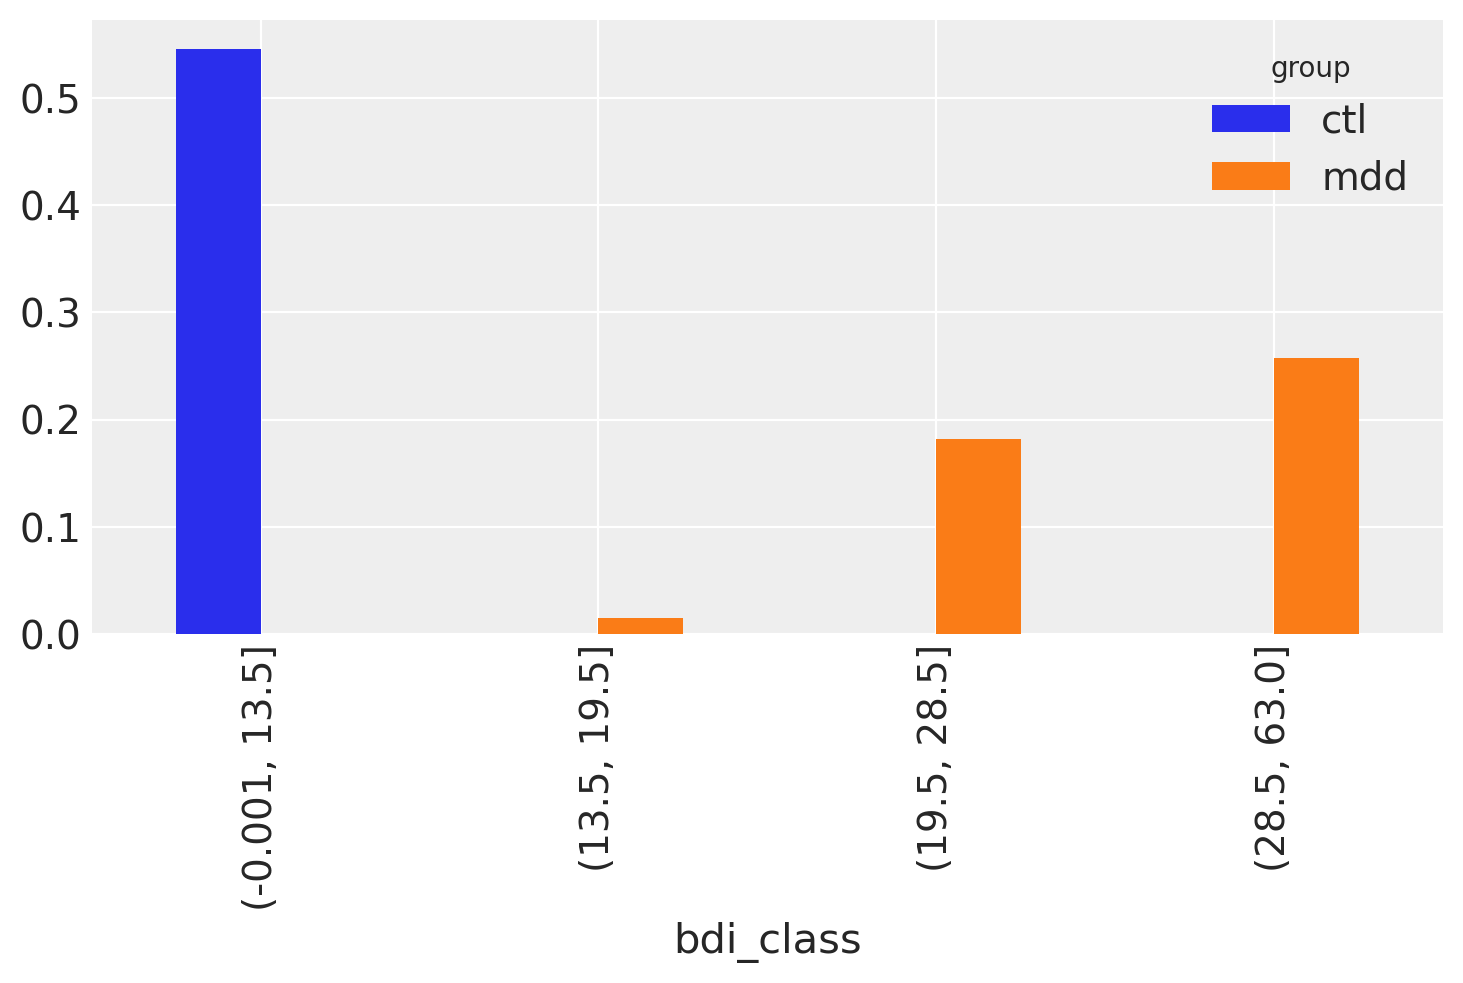

In [26]:
bdi_group_rel_freq.plot.bar();

Usando l'argomento `stacked=True`, le barre dei gruppi che si riferiscono a uno stesso valore riportato sull'asse $x$ risulteranno sovrapposte.

Possiamo calcolare le *frequenze marginali* che corrispondono ai totali calcolati rispettivamente sulle singole colonne e sulle singole righe.  

In [27]:
pd.crosstab(index=df["bdi_class"], columns=df["group"], margins=True)

group,ctl,mdd,All
bdi_class,,,
"(-0.001, 13.5]",36,0,36
"(13.5, 19.5]",0,1,1
"(19.5, 28.5]",0,12,12
"(28.5, 63.0]",0,17,17
All,36,30,66


Le frequenze congiunte trovate nell'esempio precedente erano frequenze assolute, ma è immediato estendere tale concetto a quello delle frequenze congiunte relative. Queste si possono calcolare dividendo le frequenze assolute per il numero totale di osservazioni, oppure utilizzando il parametro `normalize` in `pd.crosstab`, che però ora ha diversi valori possibili. Specificando `all` vengono calcolate le frequenze relative:

In [28]:
pd.crosstab(index=df["bdi_class"], columns=df["group"], margins=True, normalize="all")

group,ctl,mdd,All
bdi_class,,,
"(-0.001, 13.5]",0.545455,0.000000,0.545455
"(13.5, 19.5]",0.000000,0.015152,0.015152
"(19.5, 28.5]",0.000000,0.181818,0.181818
"(28.5, 63.0]",0.000000,0.257576,0.257576
All,0.545455,0.454545,1.000000


Indicando `columns` viene generata una tabella in cui tutte le colonne sommano al valore unitario:

In [29]:
pd.crosstab(
    index=df["bdi_class"], columns=df["group"], margins=True, normalize="columns"
)

group,ctl,mdd,All
bdi_class,,,
"(-0.001, 13.5]",1.0,0.000000,0.545455
"(13.5, 19.5]",0.0,0.033333,0.015152
"(19.5, 28.5]",0.0,0.400000,0.181818
"(28.5, 63.0]",0.0,0.566667,0.257576


Usando `index` si otterrà una tabella in cui i valori su ogni riga sommano a 1:

In [30]:
pd.crosstab(index=df["bdi_class"], columns=df["group"], margins=True, normalize="index")

group,ctl,mdd
bdi_class,,
"(-0.001, 13.5]",1.000000,0.000000
"(13.5, 19.5]",0.000000,1.000000
"(19.5, 28.5]",0.000000,1.000000
"(28.5, 63.0]",0.000000,1.000000
All,0.545455,0.454545


## Istogramma

Una distribuzione di frequenze può essere rappresentata graficamente attraverso un istogramma, il quale mostra sulle ascisse i limiti delle classi $\Delta_i$ e sulle ordinate la densità della frequenza relativa della variabile $X$ nella classe $\Delta_i$. La densità della frequenza relativa è misurata dalla funzione costante a tratti $\varphi_n(x)= \frac{f_i}{b_i-a_i}$, dove $f_i$ è la frequenza relativa della classe $\Delta_i$ e $b_i - a_i$ rappresenta l'ampiezza della classe. In questo modo, l'area del rettangolo associato alla classe $\Delta_i$ sull'istogramma sarà proporzionale alla frequenza relativa $f_i$. È importante notare che l'area totale dell'istogramma delle frequenze relative è uguale a 1.0, poiché rappresenta la somma delle aree dei singoli rettangoli.

Per fare un esempio, costruiamo un istogramma per i valori BDI-II di {cite:t}`zetsche_2019future`. Con i quattro intervalli individuati dai cut-off del BDI-II creo una prima versione dell'istogramma -- si notino le frequenze assolute sull'asse delle ordinate.

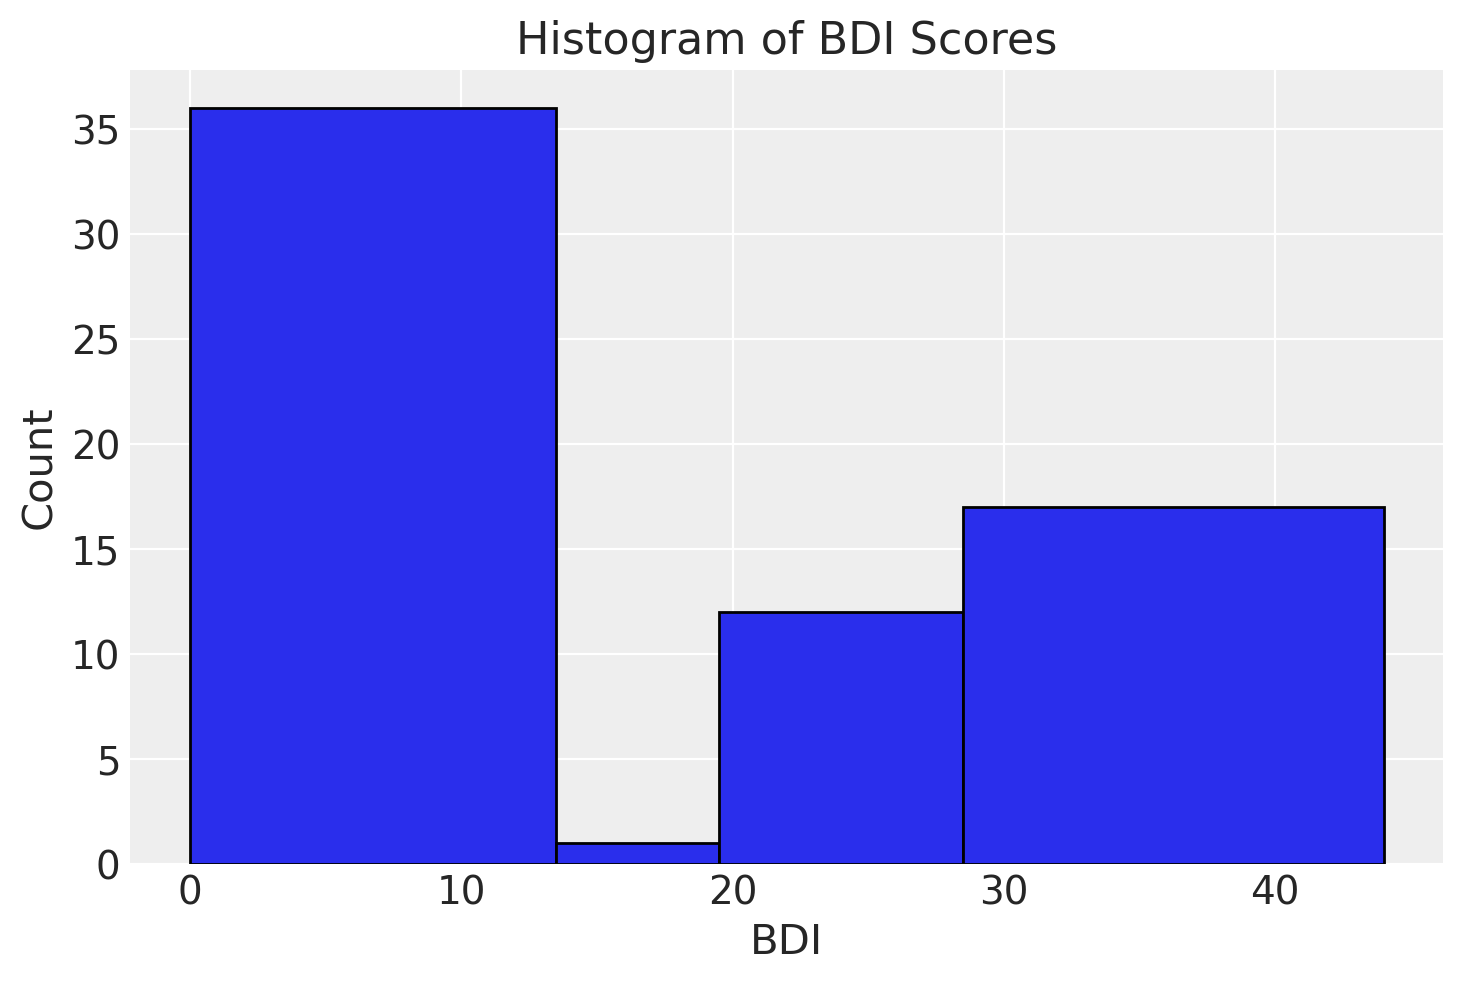

In [31]:
bdi_bins = [0, 13.5, 19.5, 28.5, 44]

plt.hist(df["bdi"], bins=bdi_bins, edgecolor="black")
plt.xlabel("BDI")
plt.ylabel("Count")
plt.title("Histogram of BDI Scores")
plt.show()

Per creare un istogramma nel quale la somma delle aree delle barre sia unitaria è necessario specificare `density=True`:

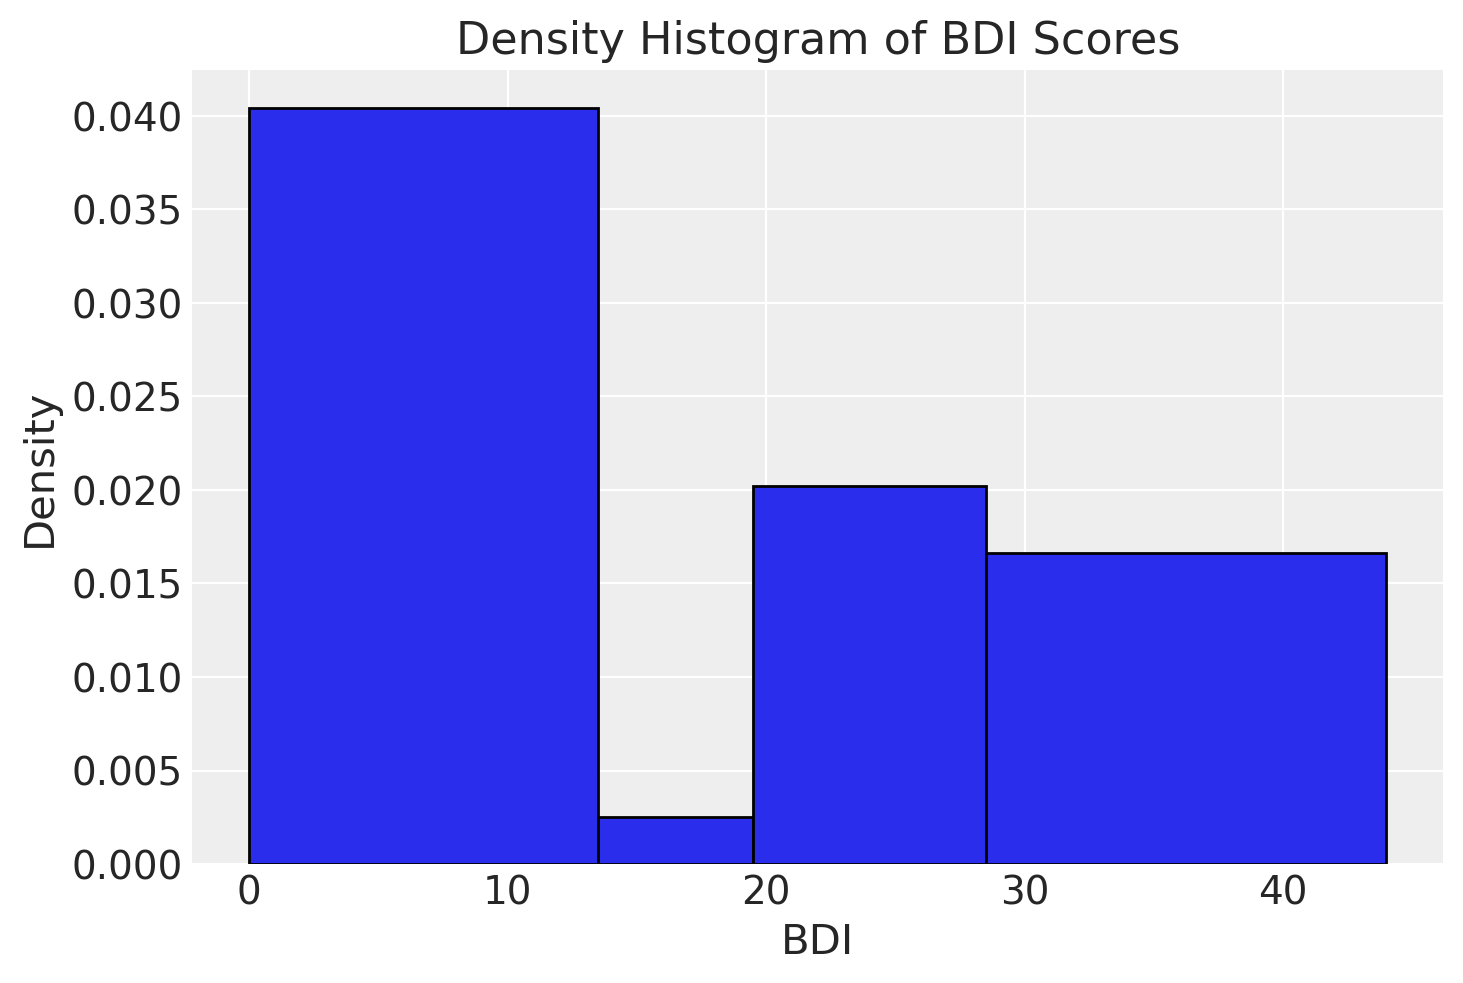

In [32]:
bdi_bins = [0, 13.5, 19.5, 28.5, 44]

plt.hist(df["bdi"], bins=bdi_bins, density=True, edgecolor="black")
plt.xlabel("BDI")
plt.ylabel("Density")
plt.title("Density Histogram of BDI Scores")
plt.show()

Anche se nel caso presente è sensato usare ampiezze diverse per gli intervalli delle classi, in generale gli istogrammi si costruiscono utilizzando intervalli riportati sulle ascisse con un'ampiezza uguale. 

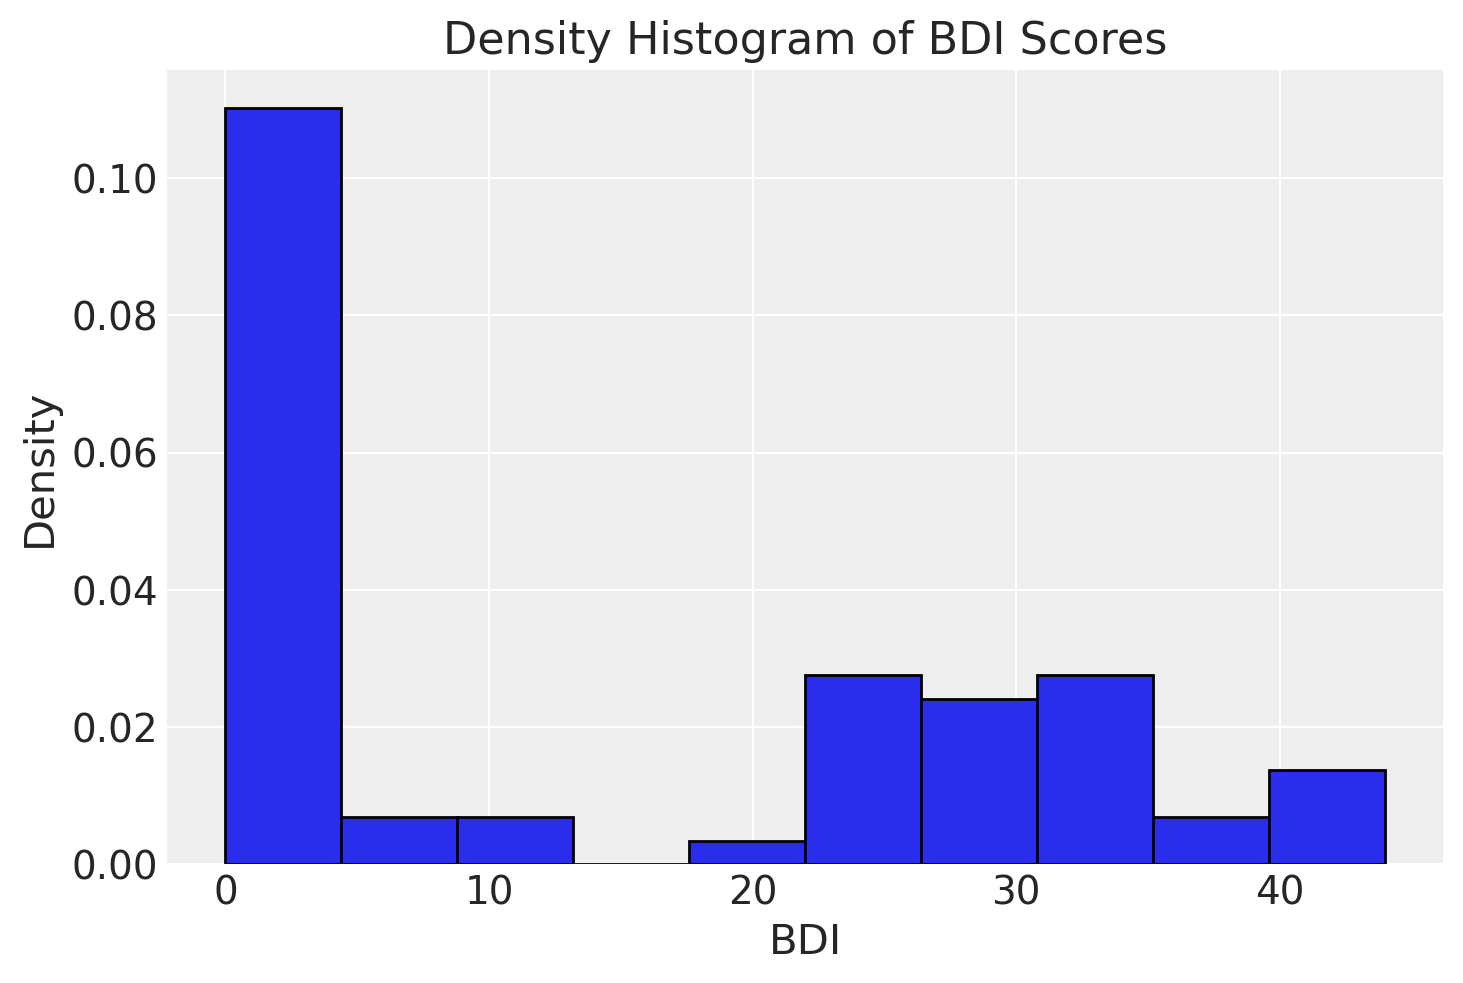

In [33]:
plt.hist(df["bdi"], density=True, edgecolor="black")
plt.xlabel("BDI")
plt.ylabel("Density")
plt.title("Density Histogram of BDI Scores")
plt.show()

## Kernel density plot

Comparando le due figure precedenti, si evidenzia la limitazione dell'istogramma: la sua forma è soggetta all'arbitrarietà del numero e dell'ampiezza delle classi, rendendo la sua interpretazione difficile.

Per ovviare a questo problema, è possibile utilizzare una rappresentazione alternativa della distribuzione di frequenza, la stima della densità della frequenza dei dati, nota anche come stima kernel di densità. Questa tecnica prevede l'immaginazione di un campione di dati molto grande, tale da permettere la definizione di numerose classi di equivalenza, di ampiezza molto ridotta, in modo che tutte siano popolate. In tal caso, la funzione di densità empirica sarà il profilo lisciato dell'istogramma. Questa stessa idea si applica anche con campioni di dati di dimensioni ridotte. Al posto di rappresentare le osservazioni in barre, come negli istogrammi, lo stimatore di densità kernel posiziona una piccola gobba (detta kernel) in corrispondenza di ogni osservazione, di altezza e larghezza determinate dai parametri di smussamento, e somma tutte le gobbe ottenute, generando così una curva smussata -- si veda l'appendice {ref}`kde-appendix`.

La curva di densità ottenuta rappresenta la proporzione di casi della distribuzione che hanno valori compresi in ogni intervallo. In altre parole, l'area sottesa al kernel density plot in un intervallo di valori indica la proporzione di casi della distribuzione che rientrano in tale intervallo.

Aggiungiamo un kernel density plot all'istogramma dei valori BDI-II di {cite:t}`zetsche_2019future`.

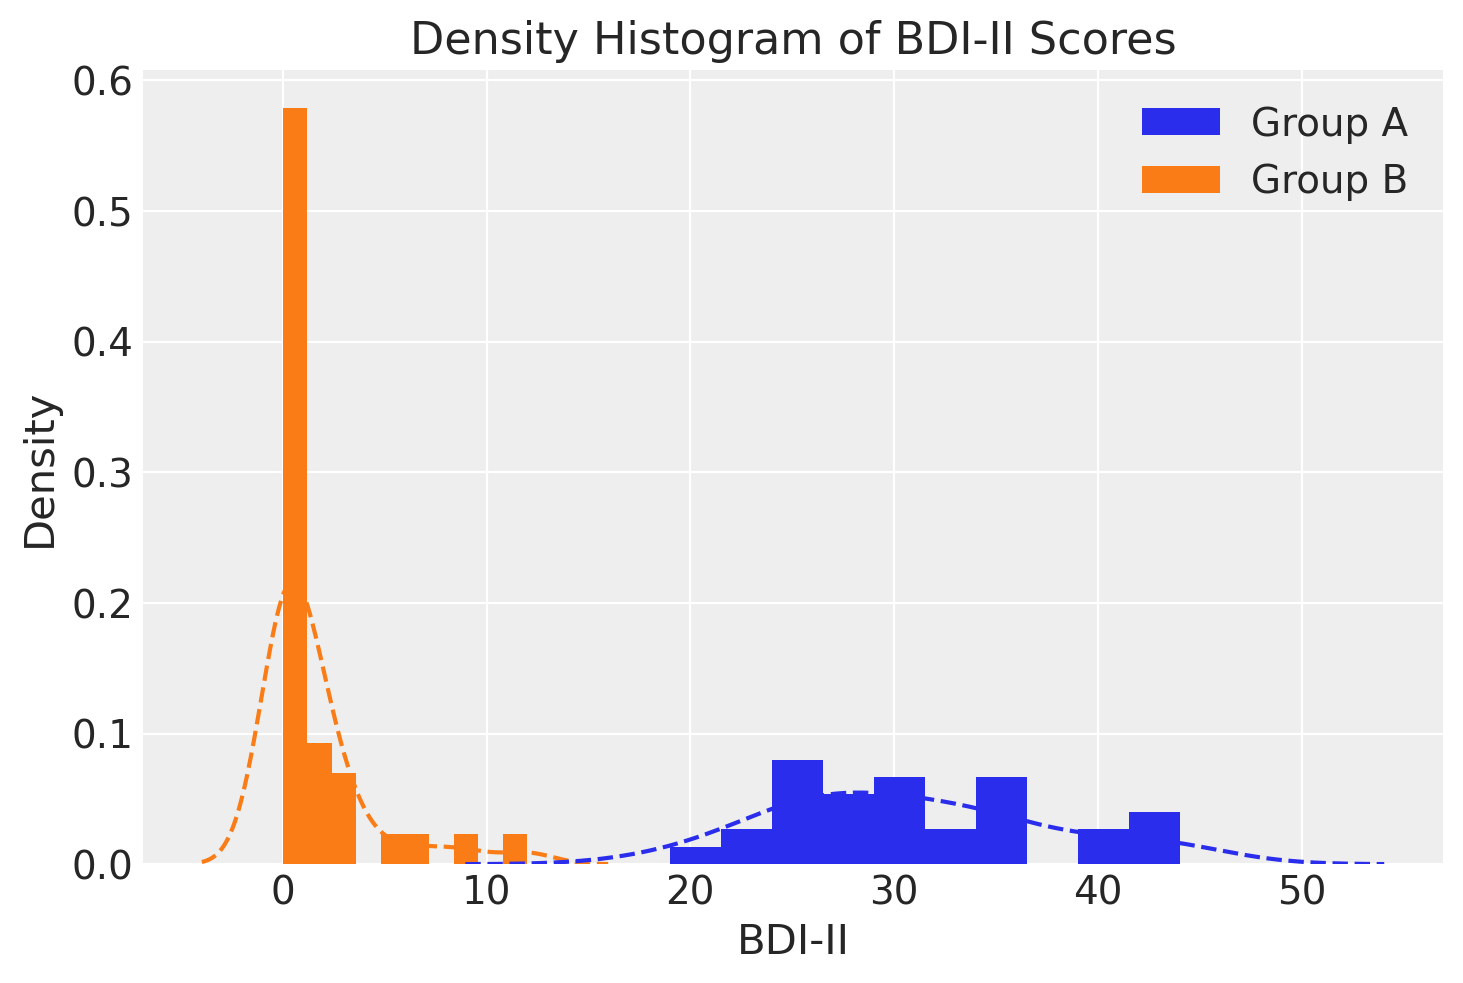

In [34]:
plt.hist(df[df["group"] == "mdd"]["bdi"], density=True, label="Group A")
plt.hist(df[df["group"] == "ctl"]["bdi"], density=True, label="Group B")
sns.kdeplot(data=df, x="bdi", hue="group", common_norm=False, linestyle='dashed')
plt.xlabel("BDI-II")
plt.ylabel("Density")
plt.title("Density Histogram of BDI-II Scores")
plt.legend()
plt.show();

## Forma di una distribuzione

In generale, la forma di una distribuzione descrive come i dati si distribuiscono intorno ai valori centrali. Distinguiamo tra distribuzioni simmetriche e asimmetriche, e tra distribuzioni unimodali o multimodali. Un'illustrazione grafica è fornita nella figura seguente. Nel pannello 1 la distribuzione è unimodale con asimmetria negativa; nel pannello 2 la distribuzione è unimodale con asimmetria positiva; nel pannello 3 la distribuzione è simmetrica e unimodale; nel pannello 4 la distribuzione è bimodale.

```{image} ../images/shape_distribution.png
:alt: shape
:class: bg-primary mb-1
:width: 420px
:align: center
```

<br> 

Il kernel density plot dei valori BDI-II nel campione di {cite:t}`zetsche_2019future` è bimodale. Ciò indica che le osservazioni della distribuzione si addensano in due cluster ben distinti: un gruppo di osservazioni tende ad avere valori BDI-II bassi, mentre l'altro gruppo tende ad avere BDI-II alti. Questi due cluster di osservazioni corrispondono al gruppo di controllo e al gruppo clinico nel campione di dati esaminato da {cite:t}`zetsche_2019future`.

## Indici di posizione

### Quantili

La distribuzione dei valori BDI-II di {cite:t}`zetsche_2019future` può essere sintetizzata attraverso l'uso dei quantili, che sono valori caratteristici che suddividono i dati in parti ugualmente numerose. I quartili sono tre quantili specifici: il primo quartile, $q_1$, divide i dati in due parti, lasciando a sinistra il 25% del campione; il secondo quartile, $q_2$, corrisponde alla mediana e divide i dati in due parti uguali; il terzo quartile lascia a sinistra il 75% del campione.

Inoltre, ci sono altri indici di posizione chiamati decili e percentili che suddividono i dati in parti di dimensioni uguali a 10% e 1%, rispettivamente.

Per calcolare i quantili, i dati vengono prima ordinati in modo crescente e poi viene determinato il valore di $np$, dove $n$ è la dimensione del campione e $p$ è l'ordine del quantile. Se $np$ non è un intero, il valore del quantile corrisponde al valore del dato che si trova alla posizione successiva alla parte intera di $np$. Se $np$ è un intero, il valore del quantile corrisponde alla media dei dati nelle posizioni $k$ e $k+1$, dove $k$ è la parte intera di $np$.

Gli indici di posizione possono essere utilizzati per creare un box-plot, una rappresentazione grafica della distribuzione dei dati che è molto popolare e può essere utilizzata in alternativa ad un istogramma.

Ad esempio, per calcolare la mediana della distribuzione dei nove soggetti con un unico episodio di depressione maggiore del campione clinico di Zetsche et al. (2019), si determina il valore di $np = 9 \cdot 0.5 = 4.5$, che non è un intero. Pertanto, il valore del secondo quartile è pari al valore del dato che si trova alla posizione successiva alla parte intera di $np$, ovvero $q_2 = x_{4 + 1} = 27$. Per calcolare il quantile di ordine $2/3$, si determina il valore di $np = 9 \cdot 2/3 = 6$, che è un intero. Quindi, il valore del quantile corrisponde alla media dei dati nelle posizioni $6$ e $7$, ovvero $q_{\frac{2}{3}} = \frac{1}{2} (x_{6} + x_{7}) = \frac{1}{2} (33 + 33) = 33$.

Usiamo `numpy` per trovare la soluzione dell'esercizio precedente.

In [35]:
x = [19, 26, 27, 28, 28, 33, 33, 41, 43]
np.quantile(x, 2 / 3)

33.0

## Mostrare i dati

### Diagramma a scatola

Il diagramma a scatola, anche chiamato box plot, è uno strumento grafico molto utile per visualizzare la dispersione di una distribuzione e per determinare se la distribuzione è simmetrica o asimmetrica. Per creare un box plot, viene disegnato un rettangolo di altezza arbitraria sulla base di una distanza interquartile (IQR), che corrisponde alla differenza tra il terzo quartile ($q_{0.75}$) e il primo quartile ($q_{0.25}$). La mediana ($q_{0.5}$) è rappresentata da una linea all'interno del rettangolo.

Ai lati della scatola, vengono tracciati due segmenti di retta che rappresentano i valori adiacenti inferiore e superiore. Il valore adiacente inferiore è il valore più basso tra le osservazioni che è maggiore o uguale al primo quartile meno 1.5 volte la distanza interquartile. Il valore adiacente superiore è il valore più alto tra le osservazioni che è minore o uguale al terzo quartile più 1.5 volte la distanza interquartile.

Se ci sono dei valori che cadono al di fuori dei valori adiacenti, vengono chiamati valori anomali e vengono rappresentati individualmente nel box plot per evidenziare la loro presenza e posizione. In questo modo, il box plot fornisce una rappresentazione visiva della distribuzione dei dati che permette di individuare facilmente eventuali valori anomali e di capire la dispersione dei dati.

```{image} ../images/boxplot.png
:alt: fishy
:class: bg-primary mb-1
:width: 640px
:align: center
```

<br> 

Utilizziamo un box-plot per rappresentare graficamente la distribuzione dei punteggi BDI-II nel gruppo dei pazienti e nel gruppo di controllo usandi i dati di {cite:t}`zetsche_2019future`.

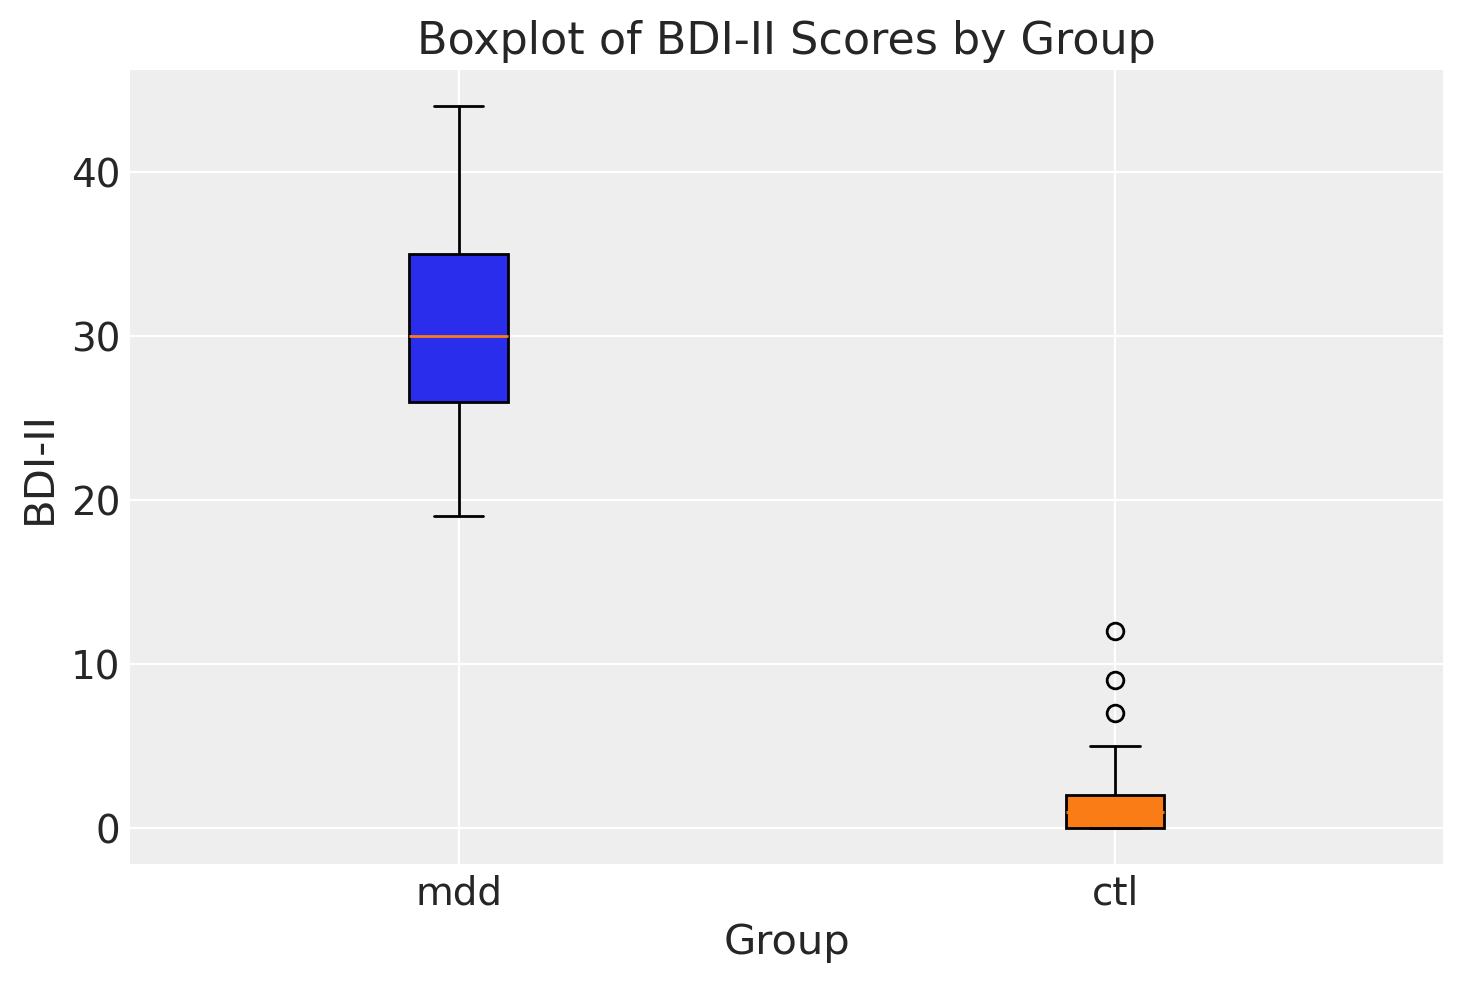

In [36]:
groups = df["group"].unique()
colors = ["C0", "C1"]

for i, group in enumerate(groups):
    subset = df[df["group"] == group]
    plt.boxplot(
        subset["bdi"],
        positions=[i],
        labels=[group],
        patch_artist=True,
        boxprops=dict(facecolor=colors[i]),
    )

plt.xlabel("Group")
plt.ylabel("BDI-II")
plt.title("Boxplot of BDI-II Scores by Group")
plt.show()

Un risultato migliore si ottiene usando un violin plot e mostrando anche i dati grezzi.

### Grafico a violino

I violin plot sono grafici che si basano sui box-plot ma che mostrano anche il profilo di densità dei dati tramite un kernel density plot. Il violin plot prende il nome dalla sua forma simmetrica, data dal kernel density plot dei dati che è riportato da entrambi i lati della distribuzione. Questo tipo di grafico può essere integrato con altre visualizzazioni dei dati, come il box-plot o il dotplot.

Di seguito è riportato un esempio di violin plot per i valori BDI-II di due gruppi di soggetti esaminati in uno studio {cite:t}`zetsche_2019future` . La curva simmetrica che attraversa il grafico è l'istogramma lisciato o kernel density plot descritto in precedenza. All'interno del violin plot è presente un box-plot e, per completezza, è stato sovrapposto un grafico a punti (dotplot). Al grafico sono sovrapposti i dati grezzi.

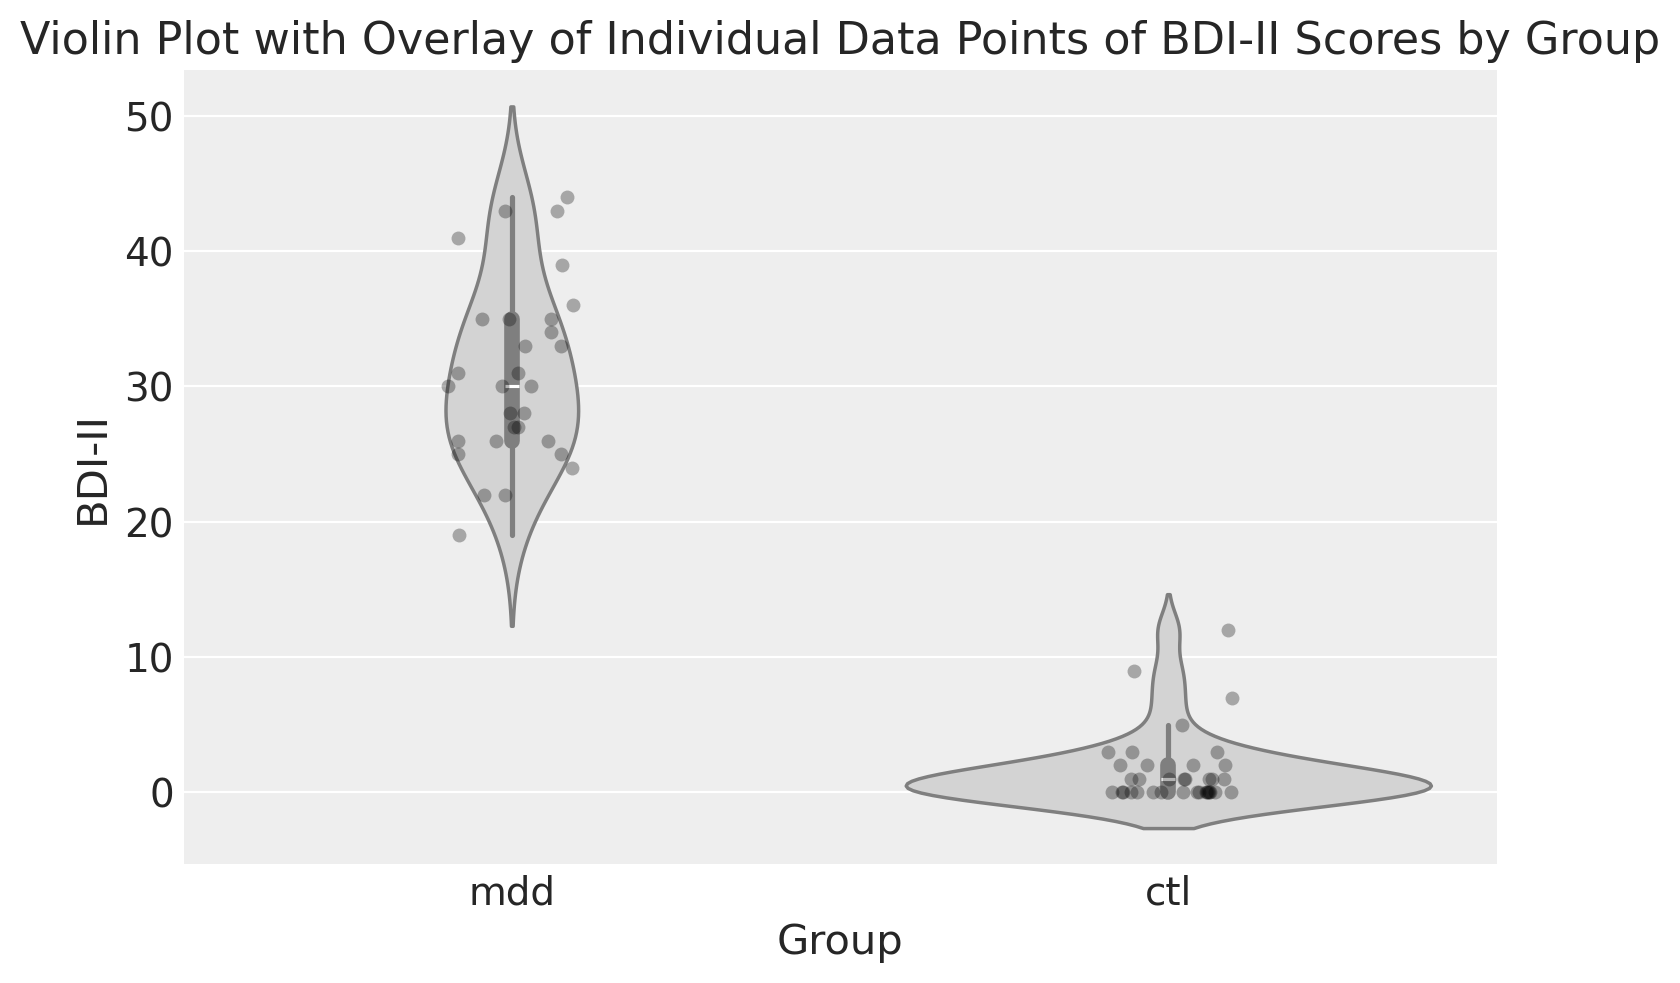

In [39]:
# Create the violin plot
sns.violinplot(x="group", y="bdi", data=df, color="lightgray")

# Overlay the individual data points using stripplot
sns.stripplot(x="group", y="bdi", data=df, color="black", size=5, jitter=True, alpha=0.3)

plt.ylabel("BDI-II")
plt.xlabel("Group")
plt.title("Violin Plot with Overlay of Individual Data Points of BDI-II Scores by Group")
plt.show()

## Commenti e considerazioni finali 

Una distribuzione rappresenta la modalità in cui le diverse valori di una variabile si distribuiscono tra le unità statistiche del campione o della popolazione in studio. Per le variabili discrete, la rappresentazione grafica più comune è quella della distribuzione di frequenza. Tuttavia, per le variabili continue, esiste una rappresentazione corrispondente che permette di visualizzare le proprietà della distribuzione.

## Ambiente di Calcolo

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 21 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

numpy     : 1.26.2
pandas    : 2.1.4
matplotlib: 3.8.2
seaborn   : 0.13.0
arviz     : 0.17.0

Watermark: 2.4.3

